# Learner

In [ ]:
from datasets import load_dataset
import torch
import fastcore.all as fc
import torchvision.transforms.functional as TF
from minai.datasets import inplace, collate_dict
from torch.utils.data import DataLoader
from torch import optim, nn
import torch.nn.functional as F
from torch import tensor
from torcheval.metrics import MulticlassAccuracy, Mean
from collections.abc import Mapping
from copy import copy
from contextlib import contextmanager
from fastprogress.fastprogress import master_bar, progress_bar
from functools import partial
import math
import matplotlib as mpl
from matplotlib import pyplot as plt

In [ ]:
dataset = load_dataset('fashion_mnist')

In [ ]:
bs = 1024
x, y = 'image', 'label'
dataset['train'][x][0]

In [ ]:
dataset['train'][y][0]

9

In [ ]:
dataset['train'].features['label'].names[9]

'Ankle boot'

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
torch.flatten(TF.to_tensor(dataset['train'][x][0])).shape

torch.Size([784])

In [ ]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
dsd = dataset.with_transform(transformi)

In [ ]:
class DataLoaders:
    def __init__(self, dls):
        self.train_dl, self.valid_dl = dls[:2]
    
    @classmethod
    def from_dd(cls, dsd):
        return cls([DataLoader(ds, batch_size=bs, collate_fn=collate_dict(ds)) for ds in dsd.values()])

In [ ]:
dls = DataLoaders.from_dd(dsd)

In [ ]:
train_dl = dls.train_dl
valid_dl = dls.valid_dl

In [ ]:
it = iter(train_dl)
xb, yb = next(it)
xb.shape, yb.shape

(torch.Size([1024, 784]), torch.Size([1024]))

In [ ]:
(torch.tensor([1, 1, 0, 1]) == torch.tensor([1, 0, 1, 0])).sum()

tensor(1)

In [ ]:
class Learner:
    def __init__(self, model, train_dl, valid_dl, lr, opt_func, loss_func):
        fc.store_attr()
    
    def one_batch(self):
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        self.loss.backward()
        self.opt.step()
        self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        n = len(self.xb)
        self.losses.append(self.loss * n)
        self.ns.append(n)
        self.accuracy.append((self.preds.argmax(-1) == self.yb).sum())
        
    def one_epoch(self, train):
        self.model.training = train
        self.losses = []
        self.ns = []
        self.accuracy = []
        dl = train_dl if self.model.training else valid_dl
        for self.xb, self.yb in dl:
            self.one_batch()
        print(f'Epoch:{self.epoch} Train:{self.model.training} Loss:{sum(self.losses)/sum(self.ns)} Accuracy: {sum(self.accuracy)/sum(self.ns)}')
        
    def fit(self, epochs):
        self.opt = self.opt_func(self.model.parameters(), lr = self.lr)
        for self.epoch in range(epochs):
            self.one_epoch(True)
            self.one_epoch(False)

In [ ]:
def get_model(): return nn.Sequential(nn.Linear(784, 50), nn.ReLU(), nn.Linear(50, 10))
learn = Learner(get_model(), train_dl, valid_dl, 0.2, optim.SGD, F.cross_entropy)

In [ ]:
learn.fit(1)

Epoch:0 Train:True Loss:1.1667500734329224 Accuracy: 0.5988666415214539
Epoch:0 Train:False Loss:0.8084695339202881 Accuracy: 0.713699996471405


## Callback

In [ ]:
class CancelEpochException(Exception): pass
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass

In [ ]:
class Callback: order = 0

In [ ]:
class CompleteCallback(Callback):
    def before_fit(self): self.num_batch = 0
    def after_batch(self): self.num_batch += 1
    def after_fit(self): print(f'Completed {self.num_batch}')

In [ ]:
cbs = [CompleteCallback()]

In [ ]:
getattr(cbs[0], 'before_fit')()
getattr(cbs[0], 'after_fit')()

Completed 0


In [ ]:
def run_cbs(cbs, f:str):
    for cb in sorted(cbs, key=lambda x: x.order):
        method = getattr(cb, f, None)
        if method: method()

In [ ]:
run_cbs(cbs, 'before_epoch')

In [ ]:
run_cbs(cbs, 'before_fit')

In [ ]:
run_cbs(cbs, 'after_fit')

Completed 0


In [ ]:
run_cbs(cbs, 'after_batch')

In [ ]:
run_cbs(cbs, 'after_fit')

Completed 1


In [ ]:
class Learner:
    def __init__(self, model, dls, lr, opt_func, loss_func, cbs=[]):
        fc.store_attr()
        for cb in self.cbs: cb.learn = self
    
    def one_batch(self):
        try:
            self.callback('before_batch')
            self.preds = self.model(self.batch[0])
            self.loss = self.loss_func(self.preds, self.batch[1])
            if self.model.training:
                self.loss.backward()
                self.opt.step()
                self.opt.zero_grad()
        except CancelBatchException: pass
        finally: self.callback('after_batch')
        
    def one_epoch(self, train):
        self.model.training = train
        self.dl = dls.train_dl if self.model.training else dls.valid_dl
        try:
            self.callback('before_epoch')
            for self.batch in self.dl:
                self.one_batch()
        except CancelEpochException: pass
        finally: self.callback('after_epoch')
        
    
    def fit(self, epochs):
        try:
            self.callback('before_fit')
            self.opt = self.opt_func(self.model.parameters(), lr = self.lr)
            for self.epoch in range(epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        finally: self.callback('after_fit')
    
    def callback(self, fn):
        run_cbs(self.cbs, fn)

In [ ]:
learn = Learner(get_model(), dls, 0.2, optim.SGD, F.cross_entropy, cbs=[CompleteCallback()])

In [ ]:
learn.fit(1)

Completed 69


In [ ]:
class SingleBatchCallback(Callback):
    def after_batch(self): raise CancelEpochException()

In [ ]:
learn = Learner(get_model(), dls, 0.2, optim.SGD, F.cross_entropy, cbs=[CompleteCallback(), SingleBatchCallback()])

In [ ]:
learn.fit(1)

Completed 2


## Metric

In [ ]:
class Metric:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.vals = []
        self.ns = []
    
    def add(self, inps, target=None, n=1):
        self.last = self.compute(inps, target)
        self.vals.append(self.last)
        self.ns.append(n)
         
    
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals) * ns).sum()/ns.sum()
        
    
    def compute(self, inps, target=None):
        return inps

In [ ]:
class Accuracy(Metric):
    def compute(self, inps, target=None):
        return (tensor(inps) == tensor(target)).float().mean()

In [ ]:
acc = Accuracy()

In [ ]:
acc.add([1, 0, 1, 0, 1], [1, 1, 1, 1, 1])

In [ ]:
acc.value

tensor(0.6000)

In [ ]:
acc.add([1, 1, 1, 1, 1], [1, 1, 1, 1, 1])

In [ ]:
acc.value

tensor(0.8000)

In [ ]:
loss = Metric()

In [ ]:
loss.add(0.9, 6)

In [ ]:
loss.add(0.8, 6)

In [ ]:
loss.value

tensor(0.8500)

In [ ]:
acc.reset(); acc.value

tensor(nan)

In [ ]:
acc = MulticlassAccuracy()

In [ ]:
acc.update(tensor([0, 0, 0, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1]))

<torcheval.metrics.classification.accuracy.MulticlassAccuracy>

In [ ]:
acc.compute()

tensor(0.5000)

In [ ]:
acc.reset(); acc.compute()

tensor(nan)

In [ ]:
mean = Mean()

In [ ]:
mean.update(torch.tensor(0.9), weight = 6)

<torcheval.metrics.aggregation.mean.Mean>

In [ ]:
mean.update(torch.tensor(0.8), weight = 6)

<torcheval.metrics.aggregation.mean.Mean>

In [ ]:
mean.compute()

tensor(0.8500, dtype=torch.float64)

## Metrics Callback

In [ ]:
def to_cpu(o):
    if isinstance(o, Mapping):  return {k: to_cpu(v) for k, v in o.items()}
    if isinstance(o, list): return [to_cpu(x) for x in o]
    if isinstance(o, tuple): return tuple(to_cpu(list(o)))
    return o.detach().cpu()

In [ ]:
to_cpu(tensor([1, 2, 3, 4]))

tensor([1, 2, 3, 4])

In [ ]:
class MetricsCallback(Callback):
    def __init__(self, *m, **metrics):
        for o in m: metrics[o.__class__.__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(self.metrics)
        self.all_metrics['loss'] = Mean()
    
    def _log(self, d): print(d)
    
    def before_fit(self):
        self.learn.metrics = self
        
    def before_epoch(self): 
        for o in self.all_metrics.values(): o.reset()
    
    def after_batch(self):
        for o in self.metrics.values(): o.update(to_cpu(self.learn.preds), self.learn.batch[1])
        self.all_metrics['loss'].update(to_cpu(self.learn.loss), weight = len(self.learn.batch[0]))
        
    def after_epoch(self):
        d = {k: o.compute().item() for k, o in self.all_metrics.items()}
        d['epoch'] = self.learn.epoch
        d['train'] = self.learn.model.training
        self._log(str(d))

In [ ]:
metrics = MetricsCallback(MulticlassAccuracy())

In [ ]:
learn = Learner(get_model(), dls, 0.2, optim.SGD, F.cross_entropy, cbs=[metrics])

In [ ]:
learn.fit(1)

{'MulticlassAccuracy': 0.60916668176651, 'loss': 1.1722128804524738, 'epoch': 0, 'train': True}
{'MulticlassAccuracy': 0.6777999997138977, 'loss': 0.8951601806640626, 'epoch': 0, 'train': False}


## New Learner

In [ ]:
class Learner:
    def __init__(self, model, dls, lr, loss_func, opt_func, cbs=[]):
        fc.store_attr()
        for cb in self.cbs: cb.learn = self
    
    @contextmanager
    def callback_ctx(self, name):
        try:
            self.callback(f'before_{name}')
            yield
        except globals()[f'Cancel{name.title()}Exception']: pass
        finally: self.callback(f'after_{name}')
        
    
    def one_epoch(self, train):
        self.model.training = train
        self.dl = dls.train_dl if self.model.training else dls.valid_dl
        with self.callback_ctx('epoch'):
            for self.batch in self.dl:
                with self.callback_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
        
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        with self.callback_ctx('fit'):
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
                
    def callback(self, fn):
        run_cbs(self.cbs, fn)
        
    def __getattr__(self, fn):
        if fn in ('get_loss', 'predict', 'step', 'zero_grad', 'backward'): return partial(self.callback, fn)
        raise AttributeError(fn)

In [ ]:
class TrainCB(Callback):
    def predict(self): self.learn.preds = self.learn.model(self.learn.batch[0])
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
    def backward(self): self.learn.loss.backward()
    def step(self): self.learn.opt.step()
    def zero_grad(self): self.learn.opt.zero_grad()

In [ ]:
class ProgressCallback(Callback):
    order = MetricsCallback.order + 1
    
    def __init__(self, plot=False): fc.store_attr()
        
    def before_fit(self): 
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        if hasattr(self.learn, 'metrics'): self.learn.metrics._log = self._log
        self.losses = []
        
    def _log(self, d): self.mbar.write(d)
        
    def before_epoch(self):
        self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
    
    def after_batch(self):
        self.mbar.child.comment = f'Loss: {self.learn.loss}'
        if self.learn.model.training and self.plot and hasattr(self.learn, 'metrics'):
            self.losses.append(self.learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])   

In [ ]:
metrics = MetricsCallback(accuracy=MulticlassAccuracy())

In [ ]:
learn = Learner(get_model(), dls, 0.2, F.cross_entropy, optim.SGD, cbs=[TrainCB(), metrics, ProgressCallback(plot=True)])

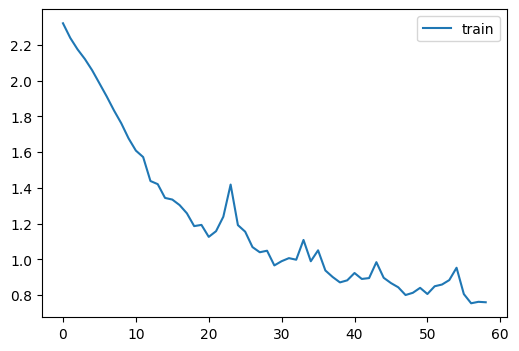

In [ ]:
learn.fit(1)

## Momentum Learner

In [ ]:
class MomentumLearner(Learner):
    def __init__(self, model, dls, lr, loss_func, opt_func, cbs = [], mom=0.8): 
        self.mom = mom
        super().__init__(model, dls, lr, loss_func, opt_func, cbs=cbs)
        
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): 
        for param in self.model.parameters():
            param.grad = self.mom * param.grad

In [ ]:
metrics = MetricsCallback(accuracy = MulticlassAccuracy())
cbs=[metrics, ProgressCallback(plot=True)]
learn = MomentumLearner(get_model(), dls, 0.2, F.cross_entropy, optim.SGD, cbs=cbs)

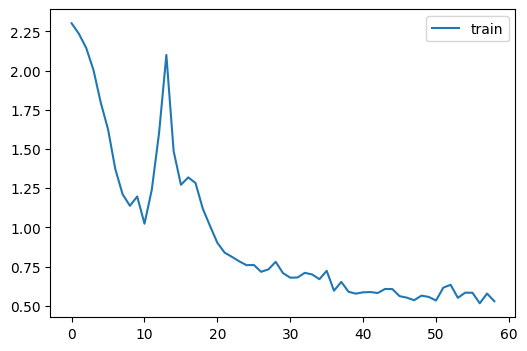

In [ ]:
learn.fit(1)

## LRFinder

In [ ]:
class LRFinderCallback(Callback):
    def __init__(self, lr_mult=1.3):
        fc.store_attr()
    
    def before_fit(self):
        self.lrs, self.losses = [], []
        self.min = math.inf
        
    def after_batch(self):
        if not self.learn.model.training: raise CancelEpochException()
        self.lrs.append(self.learn.opt.param_groups[-1]['lr'])
        self.losses.append(self.learn.loss.item())
        if self.learn.loss.item() < self.min: self.min = self.learn.loss.item()
        if self.learn.loss.item() > self.min * 3: raise CancelFitException()
        for grp in self.learn.opt.param_groups: grp['lr'] *= self.lr_mult
        
    
    def after_fit(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [ ]:
lr_find = LRFinderCallback()
metrics = MetricsCallback(accuracy=MulticlassAccuracy())
learn = MomentumLearner(get_model(), dls, 0.2, F.cross_entropy, optim.SGD, cbs=[lr_find, metrics, ProgressCallback()])

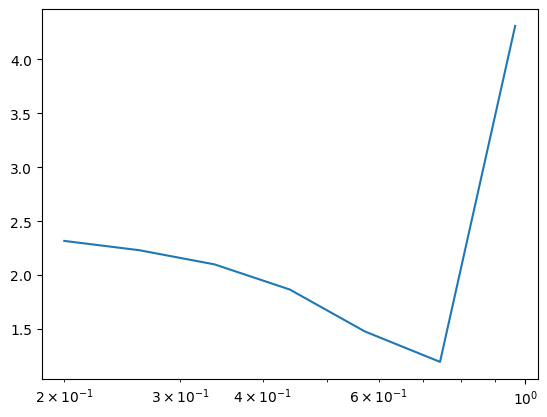

In [ ]:
learn.fit(1)

### Using ExponentialLR

In [ ]:
class LRFinderCallback(Callback):
    def __init__(self, lr_mult=1.3):
        fc.store_attr()
        
    def before_fit(self):
        self.sched = optim.lr_scheduler.ExponentialLR(self.learn.opt, gamma=self.lr_mult)
        self.lrs = []
        self.losses = []
        self.min = math.inf
        
    def after_batch(self):
        if not self.learn.model.training: raise CancelEpochException()
        loss = self.learn.loss.item()
        self.lrs.append(self.sched.get_lr()[-1])
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min * 3: raise CancelFitException() 
        self.sched.step()
    
    def after_fit(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [ ]:
lr_find = LRFinderCallback()
metrics = MetricsCallback(accuracy=MulticlassAccuracy())
learn = MomentumLearner(get_model(), dls, 0.2, F.cross_entropy, optim.SGD, cbs=[lr_find, metrics, ProgressCallback()])

/Users/anubhavmaity/mambaforge/envs/fastai/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:574: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


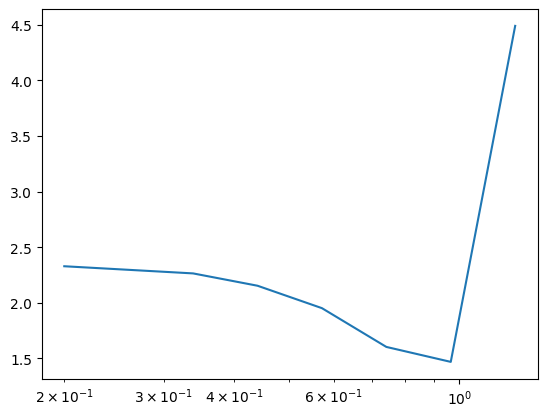

In [ ]:
learn.fit(1)